In [1]:
import uNet1D as unet
import importlib
importlib.reload(unet)
#unet=unet.unet1D(input_size = (48,3))
#print(unet.summary())
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.layers import Input, concatenate
import tensorflow as tf
nchannels=2
input_tb_size=10
noutputs=48
#noutputs=48,nchannels=1,ndense=32
tbmodel_dense=unet.tbMLP(input_tb_size,noutputs=48,nchannels=2,ndense=32)

lidarModel=unet.unet1D(input_size = (48,1),nfilters=8)
#print(lidarModel.summary())
#print(tbmodel_dense.summary())

In [4]:

def active_passive_Unet(input1_size):
    #define network with two inputs
    input1 = Input(input1_size)
    out=lidarModel(input1)
    return tf.keras.Model(input1,out)



unetRadar=active_passive_Unet(input1_size=(48,1))
#print(unetLidar.summary())
unetRadar.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.MeanSquaredError(),
        metrics=['mse'])


In [3]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from netCDF4 import Dataset

with Dataset("simObsCrossTrack_2dn_extended.nc") as fh:
    yobsL=fh["tb"][:,:]
    x2D=fh["iwc_SSRG"][:,:]
    iwc_CS=fh["iwcCS"][:,:]
    zKu=fh["zKu"][:,:]
    pnorm=fh["pnorm"][:,:]
    pmol=fh["pmol"][:,:]

#set random seed
np.random.seed(42)
nt,nchan=yobsL.shape   
lidarNoise=np.random.randn(nt,50)*0.1
pnorm=np.log10(1e-3*(pnorm)*10**lidarNoise+1e-9)
pnorm[pnorm<-8.0]=-8.0
pnormMax=pnorm.max(axis=-1)
nt,nchan=yobsL.shape
lidarEchoPeak=[]
zKuGtL=[]
#print(zKu.shape)
#stop
zKu+=np.random.randn(nt,50)
zKu[zKu<8]=0
# do pca on zKu
from sklearn.decomposition import PCA
bscatter=pnorm[:,30:45]
for i,pnorm1 in enumerate(pnorm):
    lidarEchoPeak.append([np.argmax(pnorm1)*0.24,2*pnorm1.max()])
    z1=zKu[i]
    a=np.nonzero(z1>8)
    if len(a[0])>0:
        zKuGtL.append(z1)
    else:
        zKuGtL.append(z1)
yobsL+=np.random.randn(nt,nchan)*3
zKuGtL=np.array(zKuGtL)
yobsRadiomLidar=np.concatenate((yobsL,pnorm),axis=-1)
yobsRadiomLidarRadar=np.concatenate((yobsL,lidarEchoPeak,pnorm,zKuGtL),axis=-1)
ind_train,ind_test,y_train, y_test = train_test_split(range(nt), x2D[:].sum(axis=-1)*0.24, test_size=0.33, random_state=42)
nt,nc=yobsL.shape

X1_train=yobsRadiomLidarRadar[ind_train,:]
X1_test=yobsRadiomLidarRadar[ind_test,:]
iwc_train=x2D[ind_train,:]
iwp_train=iwc_train.sum(axis=-1)*0.24
iwc_test=x2D[ind_test,:]
iwp_test=iwc_test.sum(axis=-1)*0.24

In [5]:

import pickle
with open('kmeans_iwc.pklz','rb') as f:
    kmeans_iwc=pickle.load(f)["kmeans_iwc"]

iwcCS_train=iwc_CS[ind_train,:]
iwcCS_test=iwc_CS[ind_test,:]
iwc_float=iwcCS_train[:,:].data.astype(np.float16)
labels_=kmeans_iwc.predict(iwc_float)
print(X1_train.shape)
print(iwc_train.shape)
#print(iwc_train.mean(axis=0))
import matplotlib.pyplot as plt
#plt.plot(iwc_train.mean(axis=0)[5:40],np.arange(5,40))
# import standard scaler
from sklearn.preprocessing import StandardScaler
scalerIWC = StandardScaler()
a=list(range(1,49))
#a.append(50)
scalerIWC.fit(iwc_train[:,a])
iwc_train_scaled=scalerIWC.transform(iwc_train[:,a])
iwc_test_scaled=scalerIWC.transform(iwc_test[:,a])
print(iwc_train_scaled.shape)
nC=18
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

(561647, 112)
(561647, 50)
(561647, 48)


In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X1_train)
X_train_scaled=scaler.transform(X1_train)
X_test_scaled=scaler.transform(X1_test)
#print(iwc_test_scaled.mean(axis=0))


In [10]:
a=list(range(11,59))
a=[]
a.extend(list(range(63,111)))
a=np.array(a)
print(X_test_scaled[:,a].shape)
X_train_scaled2=np.swapaxes(X_train_scaled[:,a].reshape(-1,1,48),1,2)
X_test_scaled2=np.swapaxes(X_test_scaled[:,a].reshape(-1,1,48),1,2)
unetRadar=active_passive_Unet(input1_size=(48,1))
#print(unetLidar.summary())
unetRadar.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.MeanSquaredError(),
        metrics=['mse'])
history = unetRadar.fit(
    X_train_scaled2,iwc_train_scaled[:,:],
    validation_data=(X_test_scaled2, iwc_test_scaled[:,:]),
    batch_size=128,
    epochs=10,
    verbose=1)
unetRadar.save("radarUnet_8channels_13epochs.h5")


(276633, 48)
Epoch 1/10
4388/4388 [==============================] - 144s 32ms/step - loss: 0.6319 - mse: 0.6319 - val_loss: 0.6444 - val_mse: 0.6444
Epoch 2/10
4388/4388 [==============================] - 138s 31ms/step - loss: 0.6223 - mse: 0.6223 - val_loss: 0.6368 - val_mse: 0.6368
Epoch 3/10
4388/4388 [==============================] - 136s 31ms/step - loss: 0.6111 - mse: 0.6111 - val_loss: 0.6404 - val_mse: 0.6404
Epoch 4/10
4388/4388 [==============================] - 138s 31ms/step - loss: 0.6074 - mse: 0.6074 - val_loss: 0.6333 - val_mse: 0.6333
Epoch 5/10
4388/4388 [==============================] - 141s 32ms/step - loss: 0.6066 - mse: 0.6066 - val_loss: 0.7287 - val_mse: 0.7287
Epoch 6/10
4388/4388 [==============================] - 143s 33ms/step - loss: 0.5984 - mse: 0.5984 - val_loss: 0.6459 - val_mse: 0.6459
Epoch 7/10
4388/4388 [==============================] - 144s 33ms/step - loss: 0.5984 - mse: 0.5984 - val_loss: 0.6351 - val_mse: 0.6351
Epoch 8/10
4388/4388 [======

In [11]:
#history = unetRadar.fit(
#    X_train_scaled2,iwc_train_scaled[:,:],
#    validation_data=(X_test_scaled2, iwc_test_scaled[:,:]),
#    batch_size=128,
#    epochs=3,
#    verbose=1)
#unetRadar.save("radarUnet_8channels_13epochs.h5")
iwcLR_=unetRadar.predict(X_test_scaled2)

iwcLR_=scalerIWC.inverse_transform(iwcLR_[:,:,0])

8645/8645 [==============================] - 31s 4ms/step


In [18]:
print(iwcLR_.shape)

(276633, 48, 1)


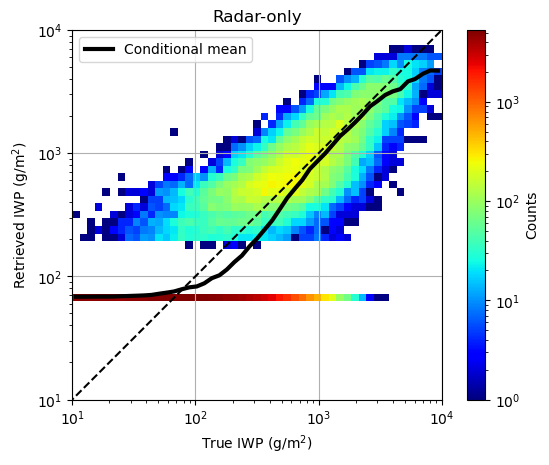

In [13]:

#iwcLR_=np.array(iwcLR_[:,:,0])
iwpLR_=np.sum(iwcLR_,axis=1)*0.24
iwp_test_=np.sum(iwc_test,axis=1)*0.24
xbins=np.logspace(1,4,50)

import matplotlib
import matplotlib.pyplot as plt
ax=plt.subplot(111)
iwp_hist=plt.hist2d(iwp_test_*1000,iwpLR_*1000,bins=xbins,norm=matplotlib.colors.LogNorm(),cmap='jet')
plt.plot([0.1,1e4],[0.1,1e4],'k--')
truthL=[]
predictionL=[]
xbins=np.logspace(1,4,50)
for i in range(49):
    a=np.nonzero((iwp_test_*1000>xbins[i]) & (iwp_test_*1000<xbins[i+1]))
    if len(a[0])>0:
        truthL.append(1000*iwp_test_[a].mean())
        predictionL.append(1000*iwpLR_[a].mean())
plt.plot(truthL,predictionL,'k-',linewidth=3,label='Conditional mean')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True IWP (g/m$^2$)")
plt.ylabel("Retrieved IWP (g/m$^2$)")
plt.title('Radar-only')
ax.set_aspect('equal')
plt.grid()
cbar=plt.colorbar(iwp_hist[-1])
cbar.set_label('Counts')
plt.savefig('radarOnly_IWP.png')


0.6748685261146874
-0.2552552744184421


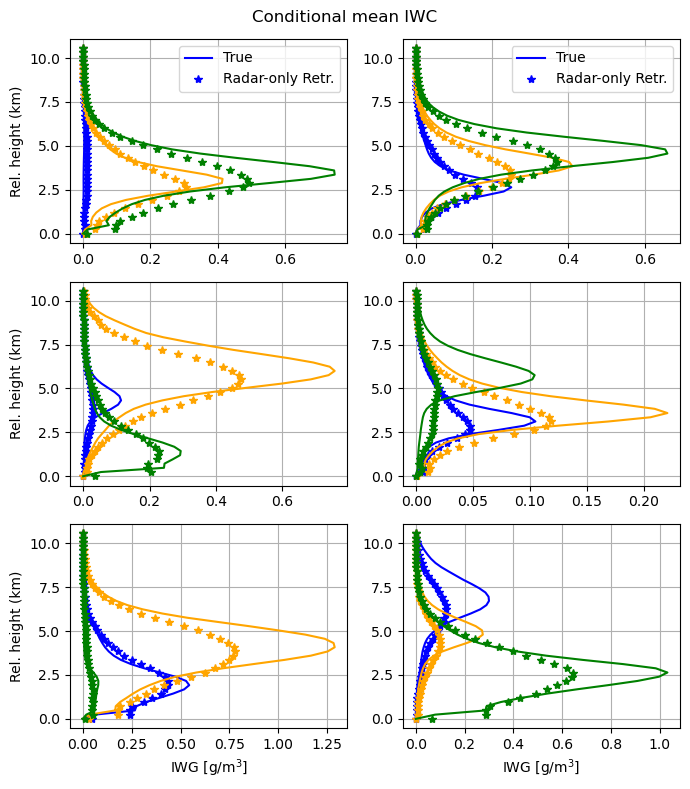

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

nC=18 # number of clusters

iwc_class_=kmeans_iwc.predict(iwc_test)
plt.figure(figsize=(7,8))

iclass=0
cols=['b','orange','g']

iwcLR_=np.array(iwcLR_)
leg1=['True',None,None]
leg2=['Radar-only Retr.',None,None]
iclass=0
for i in range(3):
    for j in range(2):
        ax=plt.subplot(3,2,i*2+j+1)
        if j>0:
            i1=1
            #ax.yaxis.set_visible(False)
            #ax.set_ylabel('')
        else:
            ax.set_ylabel('Rel. height (km)')
        if i==3:
            ax.set_xlabel('IWG [g/m3]')
        #ax.xaxis.set_visible(False)
        for k in range(3):
            a=np.nonzero(iwc_class_==iclass)[0]
            if len(a)>0:
                plt.plot((iwc_test[a,:45]).mean(axis=0),np.arange(0,45)*0.24,color=cols[k],label=leg1[k])
                plt.plot((iwcLR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'*',color=cols[k],label=leg2[k])
                #plt.plot((iwcR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'o',color=cols[k])
            # plot yticks no labels
                ax.set_yticks(np.arange(0,12.5,2.5))
                ax.grid()
            iclass+=1
        if i==2:
            ax.set_xlabel('IWG [g/m$^3$]')
        if i==0:
            plt.legend()
            #ax.set_ylabel('Rel. height (km)')
plt.suptitle('Conditional mean IWC')
plt.tight_layout()
plt.savefig('radarOnlyIWC_Prof.png')
def nrms(iwc1,iwc2):
    return np.sqrt(np.mean((iwc1.flatten()-iwc2.flatten())**2))/np.sqrt(np.mean(iwc1.flatten()**2))
print(nrms(iwc_test[:,1:49],iwcLR_))
def bias(iwc1,iwc2):
    return np.mean(-(iwc1.flatten()-iwc2.flatten())/iwc1.flatten())
def bias(iwc1,iwc2):
    return np.mean(iwc1.flatten()-iwc2.flatten())/np.mean(iwc1.flatten())*100
print(bias(iwc_test[:,1:49],iwcLR_))


(276633, 50)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_26303/432456216.py:15: RuntimeWarning: invalid value encountered in double_scalars
  hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()


[[1.         0.37959128]
 [0.37959128 1.        ]]


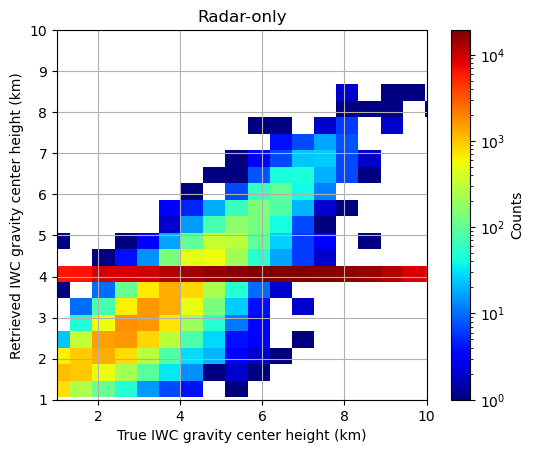

In [16]:
import matplotlib
hgRealL=[]
hgPredL=[]
#print(iwcL_.shape)
print(iwc_test.shape)
for i,iwc1 in enumerate(iwcLR_):
    #hc1=(iwc1*np.arange(50)).sum()*0.24/iwc1.sum()
    #hc2=(iwc_test[i,:]*np.arange(50)).sum()*0.24/iwc_test[i,:].sum()
    a1=np.nonzero(iwc1>0.0001)
    hc1=np.argmax(iwc1)*0.24
    hc2=np.argmax(iwc_test[i,:])*0.24
    h=np.arange(50)
    if len(a1[0])>2:
        hc1=(iwc1[a1]*h[a1]).sum()*0.24/iwc1[a1].sum()
        hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()
    #print(hc1,hc2)
    if hc1>0 and hc2>0:
        hgRealL.append(hc2)
        hgPredL.append(hc1)
plt.figure()
ax=plt.subplot(111)
hist2d_=plt.hist2d(hgRealL,hgPredL,bins=20,cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')
plt.grid()
plt.xlabel('True IWC gravity center height (km)')
plt.ylabel('Retrieved IWC gravity center height (km)')
plt.xlim(1,10)
plt.ylim(1,10)
cbar=plt.colorbar(hist2d_[-1])
plt.title('Radar-only')
cbar.set_label('Counts')
plt.savefig('radarOnly_GC.png')
print(np.corrcoef(hgRealL,hgPredL))

0.5637460439352303
